In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt

In [2]:
def softmax(x, axis=None):
    x = x - np.max(x, axis=axis, keepdims=True)
    y = np.exp(x)
    return y / np.sum(y, axis=axis, keepdims=True)

In [3]:
def loss(X, Y, W):
    Z = - X @ W
    N = X.shape[0]
    loss = 1/N * (np.trace(X @ W @ Y.T) +
                  np.sum(np.log(np.sum(np.exp(Z), axis=1)))) # Since the Loss works on the output of the model, It expects the Y to be onehot encoded
    return loss

In [4]:
def gradient_l2(X, Y, W, mu):

    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + 2 * mu * W    # Since the Loss works on the output of the model, It expects the Y to be onehot encoded
    return gd

In [5]:
def gradient_l1(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P)) + mu * np.sign(W)
    return gd

In [6]:
def gradient(X, Y, W, mu):
    """
    Y: onehot encoded 
    """
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * (X.T @ (Y - P))
    return gd

In [7]:
gradient = gradient

In [8]:
def gradient_descent(X, Y, max_iter=1000, eta=0.05, mu=0.01, save_plot=False):
    """
    X: N x D
    Y: N x 1
    """
    # One-hot encode the labels
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
    
    # Initialize the weights to zeros
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    
    # Track the steps, weights, and losses
    step = 0
    step_lst = [] 
    loss_lst = []
    W_lst = []
    
    # Iterate until the max number of iterations
    while step < max_iter:
        step += 1
        
        # Update the weights
        W -= eta * gradient(X, Y_onehot, W, mu)
        
        # Track the step, weights, and loss
        step_lst.append(step)
        W_lst.append(W)
        loss_lst.append(loss(X, Y_onehot, W))

    # Save the steps, weights, and losses
    df = pd.DataFrame({
        'step': step_lst, 
        'loss': loss_lst
    })
    return df, W

In [9]:
class Multiclass:
    def fit(self, X, Y):
        self.loss_steps, self.W = gradient_descent(X, Y, mu=0.01)

    def loss_plot(self):
        return self.loss_steps.plot(
            x='step', 
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, H):
        Z = - H @ self.W
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)
    
    def accuracy(self, H, Y):
        return np.mean(self.predict(H) == Y)

    def confusion_matrix(self, H, Y):
        return pd.crosstab(
            Y, 
            self.predict(H), 
            rownames=['Actual'], 
            colnames=['Predicted']
        )

    def loss(self, X, Y):
        Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1,1))
        return loss(X, Y_onehot, self.W)

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 22})

In [11]:
df = pd.DataFrame(load_iris().data, columns=load_iris().feature_names)
df['class'] = load_iris().target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


<AxesSubplot:xlabel='step', ylabel='loss'>

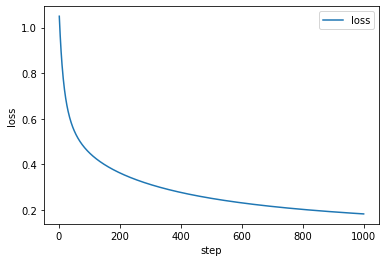

In [15]:
X = load_iris().data
Y = load_iris().target

# fit model
model = Multiclass()
model.fit(X, Y)

# plot loss
model.loss_plot()

In [16]:
# l1
model.accuracy(X, Y)

0.9733333333333334

In [88]:
# l2
model.accuracy(X, Y)

0.9666666666666667

In [75]:
model.accuracy(X, Y)

0.9733333333333334

In [22]:
model.loss(X, Y)

0.2217791307087392

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

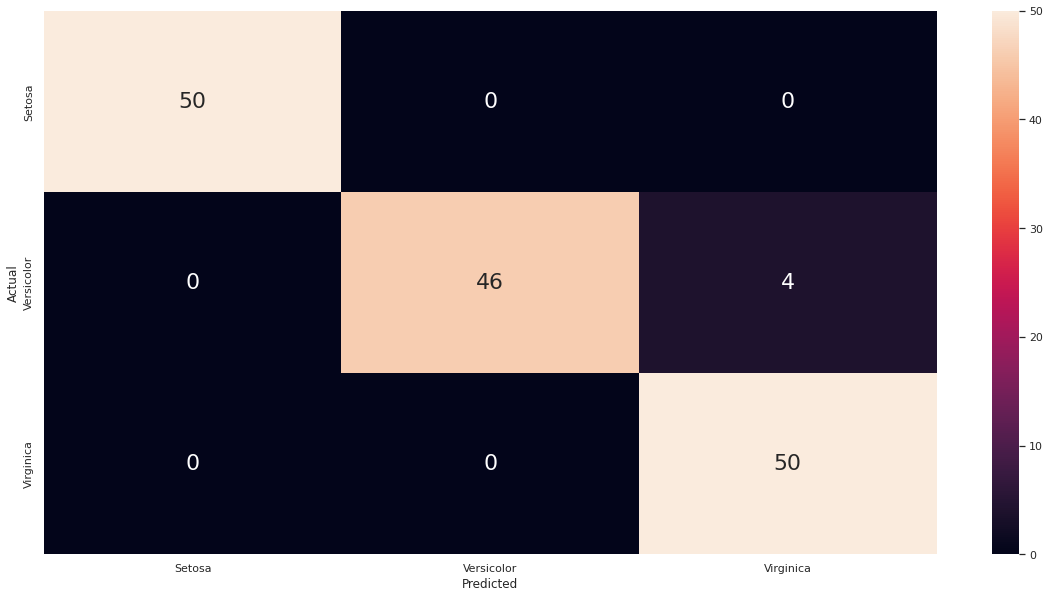

In [23]:
import seaborn as sns

df = pd.DataFrame(model.confusion_matrix(X, Y))
df = df.rename(columns={0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
df = df.rename(index={0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
sns.heatmap(df, annot=True)

<AxesSubplot:xlabel='step', ylabel='loss'>

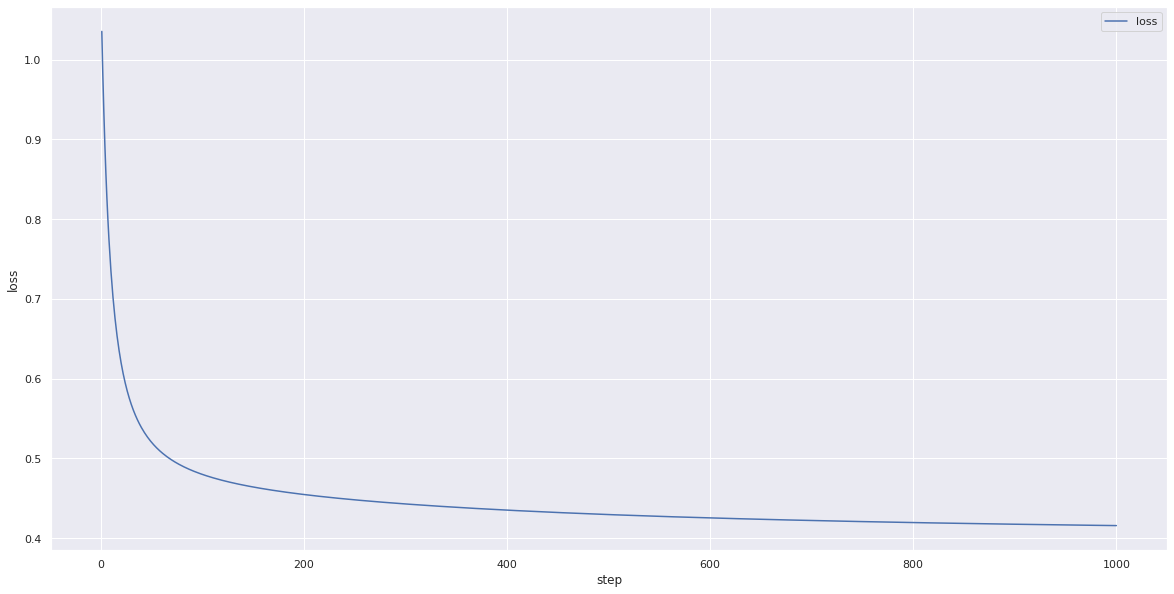

In [24]:
# Convert iris into 2 feature 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# fit model
model = Multiclass()
model.fit(X_pca, Y)

# plot loss
model.loss_plot()

In [25]:
model.accuracy(X_pca, Y)

0.8

In [26]:
model.loss(X_pca, Y)

0.4156716314210527

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

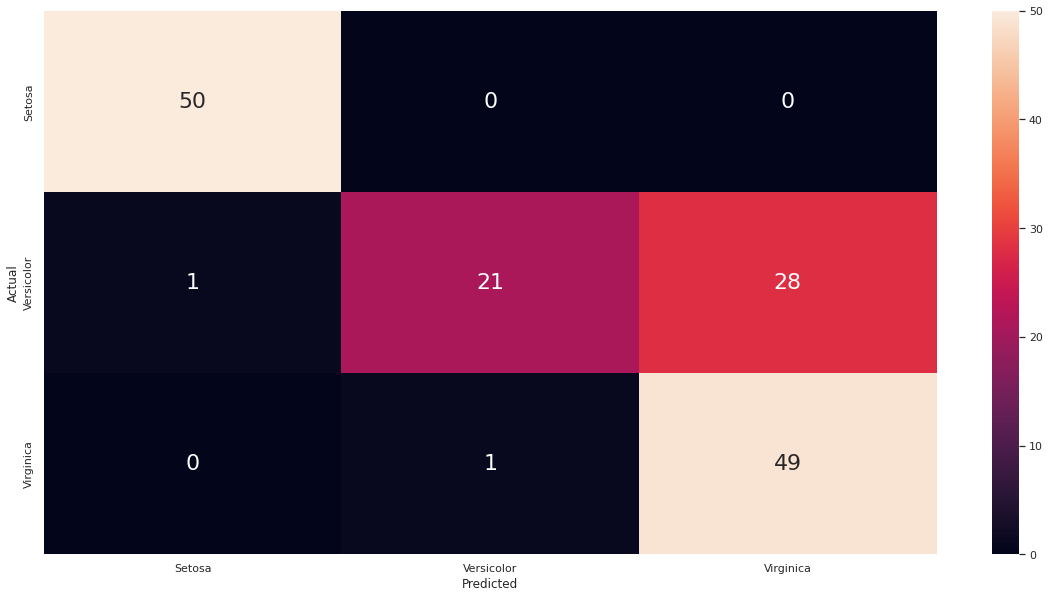

In [27]:
df = pd.DataFrame(model.confusion_matrix(X_pca, Y))
df = df.rename(columns={0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
df = df.rename(index={0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})
sns.heatmap(df, annot=True)


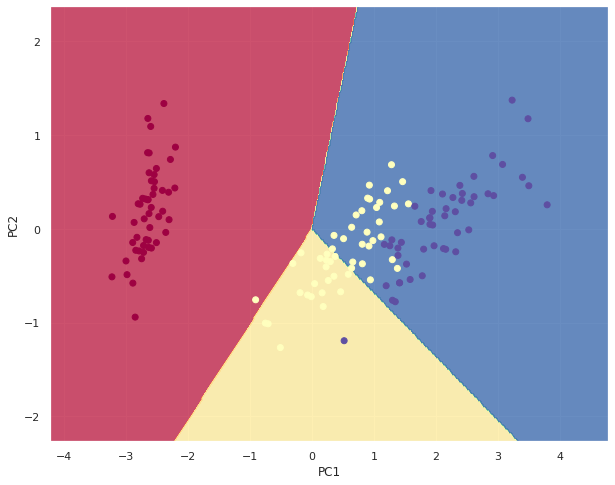

In [28]:
# plot the decision boundary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Create a mesh to plot in
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot the decision boundary
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [101]:
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
Y = digits.target

In [102]:
# fit model
model = Multiclass()
model.fit(X, Y)

In [103]:
model.accuracy(X, Y)

0.998330550918197